In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


# Exploratory Data Analysis

Importing modules and getting the data

In [3]:
# Core Modules
import pandas as pd
import numpy as np

# Basic modules for data visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [4]:
# Load data into a pandas DataFrame from given filepath
train_path="../input/house-prices-advanced-regression-techniques/train.csv"
test_path="../input/house-prices-advanced-regression-techniques/test.csv"

train=pd.read_csv(train_path)
test=pd.read_csv(test_path)

housing = train

In [5]:
# Getting column names of the dataframe
housing.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
# Getting number of features and observations
housing.shape

(1460, 81)

There are 1460 training examples in the dataset and 81 attributes.
One attribute is SalePrice which is the target variable and another the house Id, we can then say that we have 79 attributes that we can use for the analysis.

In [7]:
# Exploring the top of the dataframe
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# I drop the column Id because it is not a useful attribute, and I check the description of the data
housing = housing.drop("Id", axis=1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

We have a mix of numerical and categorical variables. Several variebles have null values.

In [9]:
# List of numerical attributes
num = housing.select_dtypes(exclude=['object']).columns
print(num)
print(len(num))

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
37


In [10]:
# List of categorical attributes
cat = housing.select_dtypes(exclude=['number']).columns
print(cat)
print(len(cat))

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
43


There are 37 numerical and 43 categorical attributes in the dataset.
We get statistical summary for each of the two.

In [11]:
#  Descriptive statistics with up to 2 decimals
# call transpose() for a better view of the results
housing.select_dtypes(exclude=['object']).describe().round(decimals=2).transpose()

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.90,42.30,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.05,24.28,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.83,9981.26,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.10,1.38,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.58,1.11,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.27,30.20,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.87,20.65,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.69,181.07,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.64,456.10,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.55,161.32,0.0,0.00,0.0,0.00,1474.0


In [12]:
# Descriptive statistics of the categorical value
housing.select_dtypes(exclude=['number']).describe().round(decimals=2).transpose()

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


For the categorical attributes we get the number of unique values and the top value for each attribute.
For example 'HouseStyle' has 8 unique values, of which '1Story' is the most common with 726 occurrances.

In [13]:
# Descriptive statistics summary of the target variable
housing['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

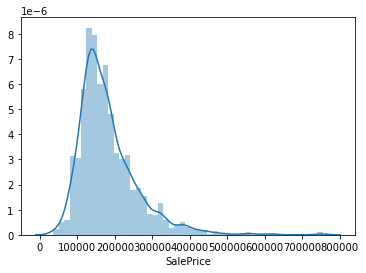

In [14]:
# Distribution plot of the target variable
sns.distplot(housing['SalePrice']);

From the plot we see that the variable is skewed, in fact the summary statistics indicate that 50% of the prices are below 163k (median) while the average price is 180k.

I apply a log transformation, by taking the log of the variable, in order to reduce the skew. This is important because I am going to apply linear regression which does not handle very good skewed data.

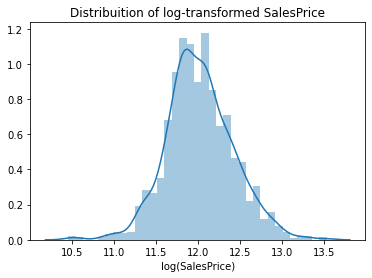

In [15]:
# Log transformation to make the distribution more normal
sns.distplot(np.log(housing['SalePrice']))
plt.title('Distribuition of log-transformed SalesPrice')
plt.xlabel('log(SalesPrice)')
plt.show()

The plot looks now more normally distributed.

We can plot the distribution of the other 36 numerical attributes as well.
 

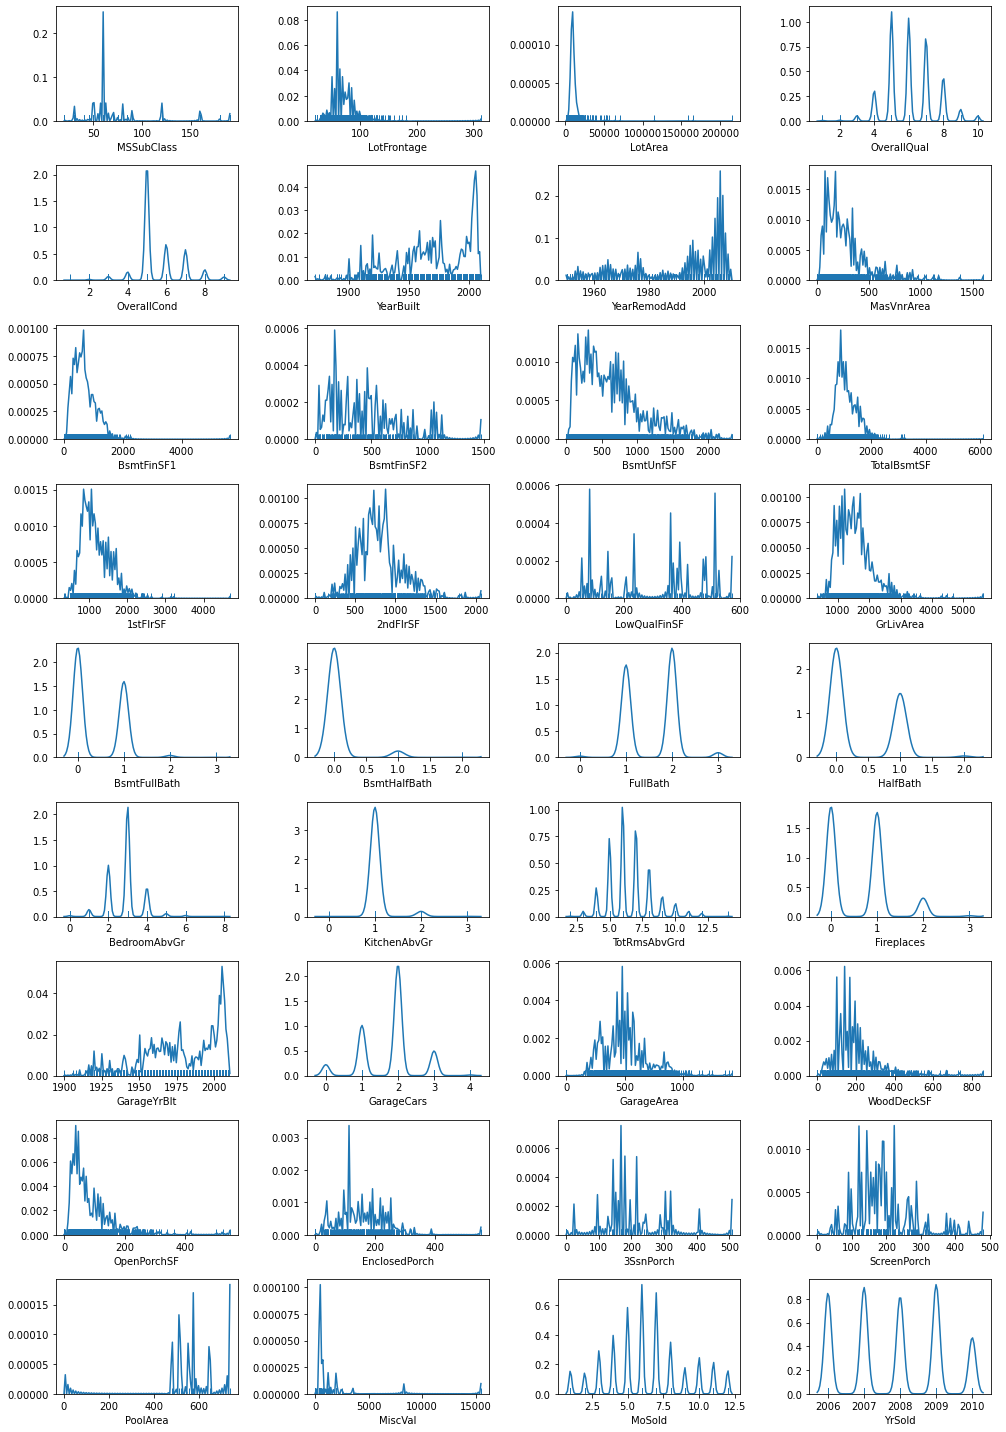

In [16]:
# Filtering and create a copy of the numerical variables and excluding SalePrice
num_var = housing.select_dtypes(exclude = ['object']).drop(['SalePrice'], axis=1).copy()

# Plotting the variables
fig  = plt.figure(figsize=(14,20))
for i in range (len(num_var.columns)):
    fig.add_subplot(9, 4, i+1) # (nrows, ncols, index)
    #narrowing the bandwidth with kde_kws https://stackoverflow.com/a/61924418
    #hist= plot a (normed) histogram.
    #rug = draw a rugplot on the support axis.
    sns.distplot(num_var.iloc[:,i].dropna(), kde_kws={'bw': 0.1}, hist = False, rug = True)
    plt.xlabel(num_var.columns[i])
    
plt.tight_layout()
plt.show()

The plot show that the variables have different distributions and scales. 
Some Variables are very skewed such as 'LotArea'.

### Dealing with outliers

We can use box plots to spot outliers.

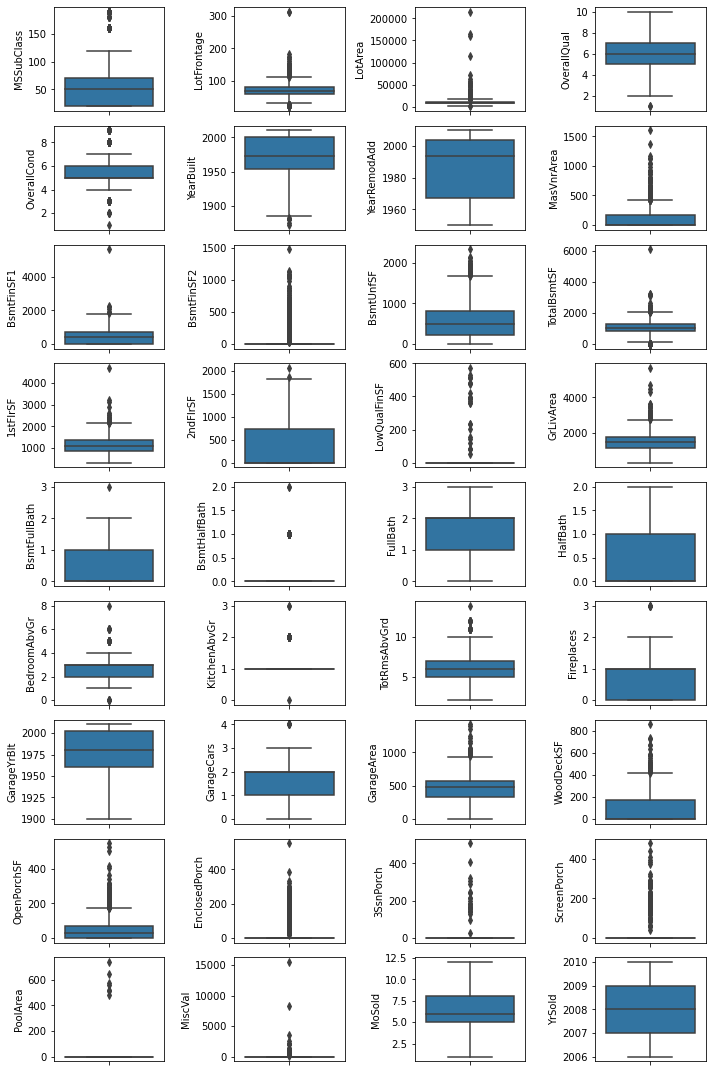

In [17]:
# Plotting the variables on box plots
fig  = plt.figure(figsize=(10,15))
for i in range (len(num_var.columns)):
    fig.add_subplot(9, 4, i+1) # (nrows, ncols, index)
    sns.boxplot(y=num_var.iloc[:,i].dropna())
    
plt.tight_layout()
plt.show()

From a visual exploartion of the variables throught the box plots above, we can see that some variables have outliers, such as 'LotFrontage' (values above 200) and 'LotArea' (values above 150000).

### Correlations among numerical variables

We check whether some pairs of variables are highly correlated and remove them. Ideally we would like independent features.

We use the corr() method which returns the correlation for all pairs of variables in a range between -1 and 1, which 0 meaning no correlation. 

We visualize the correlation with a heatmap.

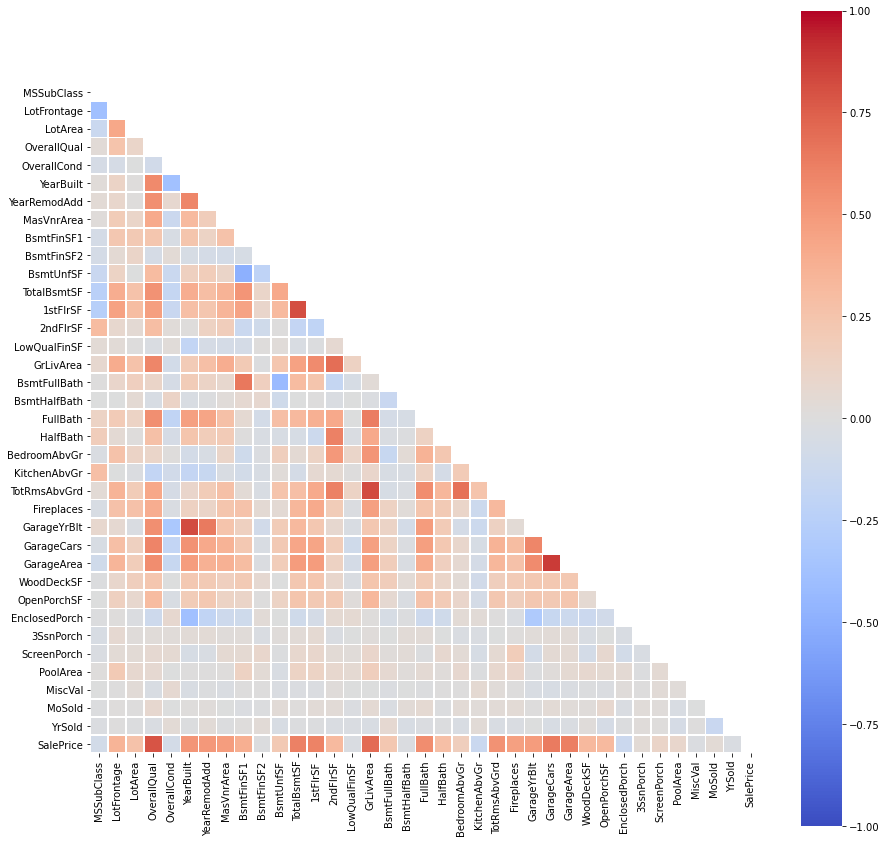

In [18]:
# Correlation of numerical variables
corr = housing.corr()

# Using mask to get triangular correlation matrix
# https://www.kdnuggets.com/2019/07/annotated-heatmaps-correlation-matrix.html
f, ax = plt.subplots(figsize = (15,15))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

sns.heatmap(corr, 
            mask=mask, 
#             cmap=sns.diverging_palette(220,10, as_cmap=True), 
            cmap = 'coolwarm',
            square = True, 
            ax=ax, 
            vmin = -1.0, 
            vmax =1.0, 
            linewidths = .5)

The heatmap shows some high correlations with the SalePrice (dark orange/red). We check the actual values of the correlations to confirm this.

In [19]:
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

'OverallQual' and 'GrLivArea' seem highly correlated with 'SalePrice' because their values are close to 1. This means that when one of the two variables increase, SalePrice increase as well. 'PoolArea' and 'MoSold' have values close to 0 so they are not correlated to 'SalePrice'.

We create a scatterplot of these two highest correlated variables with 'SalePrice' to have a better visualisation of the relationship.

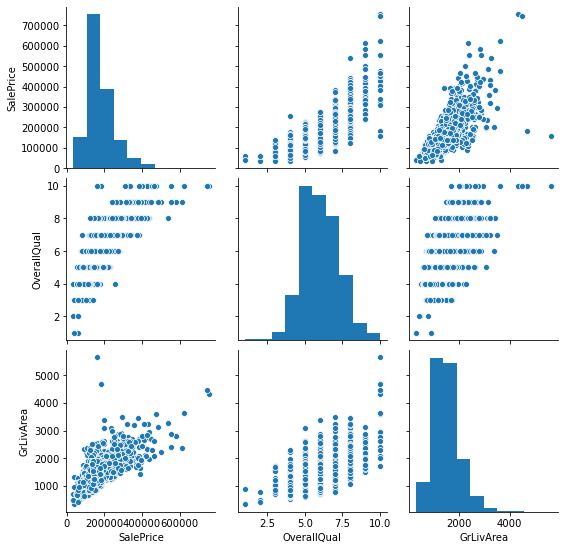

In [20]:
var = ['SalePrice', 'OverallQual', 'GrLivArea']
sns.pairplot(housing[var])

Again we see that as the 'OverallQual' and 'GrLivArea' are highly correlated with 'SalePrice' : as one of the variables increase, SalePrice increases.

We can show this relationship with different plots as well.

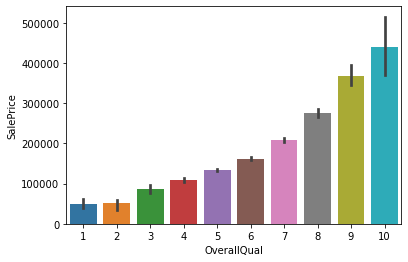

In [21]:
# Barplot
sns.barplot(housing.OverallQual, housing.SalePrice)

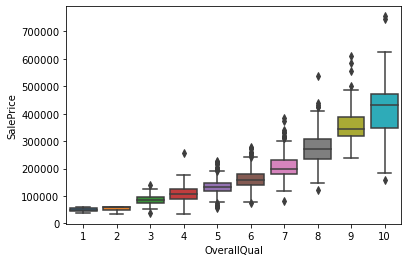

In [22]:
# Boxplot
sns.boxplot(x=housing.OverallQual, y=housing.SalePrice)

These plots show again that as the overall quality of the house the price increase, but they also show that houses with higher quality have more variety in prices. 

We explore the relationship between SalePrice and YearBuilt, to check whether the age of the house influeces its price.

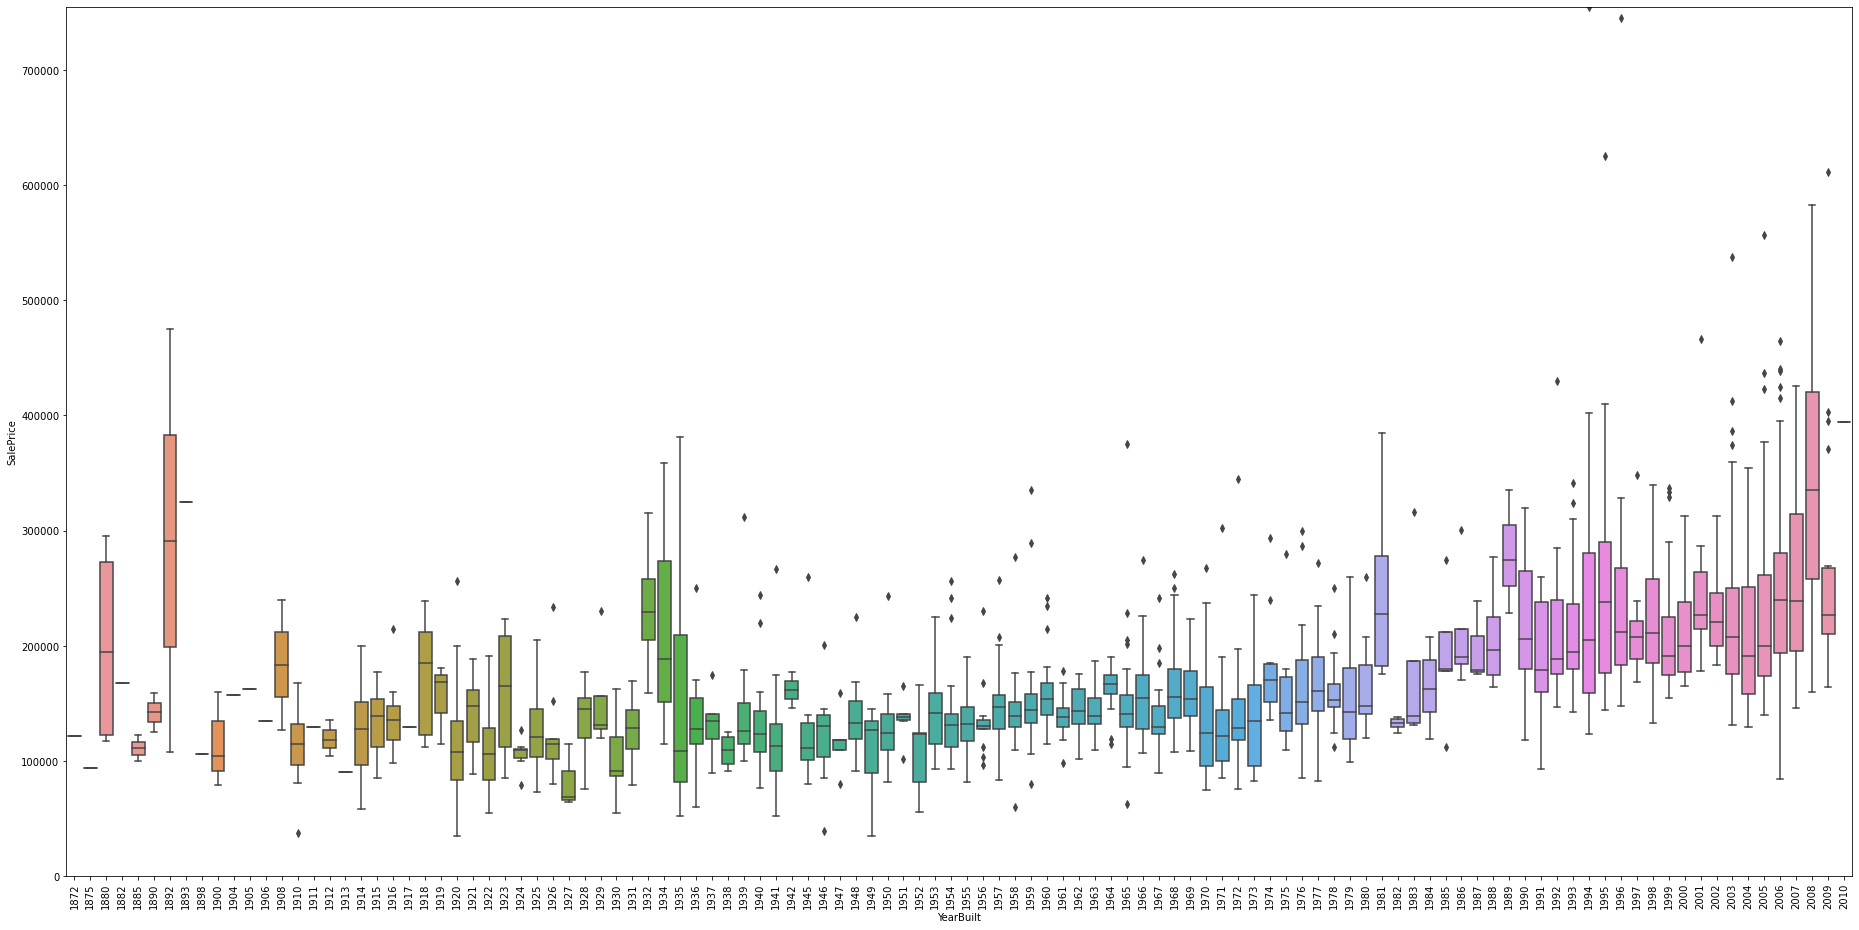

In [23]:
# Creating a dataframe with only the variables of interest
age_price = pd.concat([housing['SalePrice'], housing['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(32, 16))
fig = sns.boxplot(x='YearBuilt', y='SalePrice', data=age_price)
fig.axis(ymin=0, ymax=housing['SalePrice'].max());
plt.xticks(rotation=90);


We get the correlation for all the other variables as well. If two variables are hightly correlated we can consider removing one of them.

In [24]:
# Only correlations above 0.5 and not auto-correlations, remove NaN and build a dictionary
# unstack to output a series
high_corrs = (corr[abs(corr) > 0.5][corr != 1.0]).unstack().dropna().to_dict()
unique_high_corrs = pd.DataFrame(list(set([(tuple(sorted(key)), 
                                            high_corrs[key])for key in high_corrs])), 
                                 columns=['attribute pair', 'correlation'])

# Sorted by absolute value
unique_high_corrs = unique_high_corrs.iloc[abs(unique_high_corrs['correlation']).argsort()[::-1]]

unique_high_corrs    

,attribute pair,correlation
11,"(GarageArea, GarageCars)",0.882475
20,"(GarageYrBlt, YearBuilt)",0.825667
7,"(GrLivArea, TotRmsAbvGrd)",0.825489
28,"(1stFlrSF, TotalBsmtSF)",0.819530
2,"(OverallQual, SalePrice)",0.790982
32,"(GrLivArea, SalePrice)",0.708624
30,"(2ndFlrSF, GrLivArea)",0.687501
10,"(BedroomAbvGr, TotRmsAbvGrd)",0.676620
3,"(BsmtFinSF1, BsmtFullBath)",0.649212
13,"(GarageYrBlt, YearRemodAdd)",0.642277


GarageCars and GarageArea are highly correlated. Because they also intuitively express similar features, we can drop one of them. Specifically it is better to drop GarageArea, since GarageCars is also highly correlated with SalePrice. 
We can also drop varibles that have very small correlation with SalePrice, such as MoSold, 3SsnPorch and BsmtFinSF2.

### Explore categorical attributes

We now do some exploratory data analysis on the categorical attributes

In [25]:
cat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

We check the relationship between KitchenQual and prices.

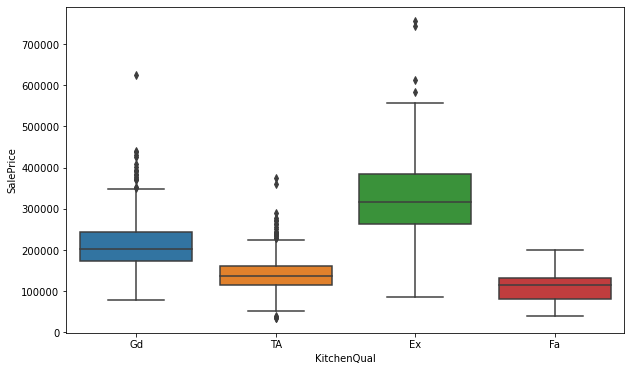

In [26]:
# Boxplot
f, ax = plt.subplots(figsize = (10,6))
sns.boxplot(x=housing.KitchenQual, y=housing.SalePrice)
plt.show()

Houses with KitchenQual value Ex are more expensive (and also have slightly more variety in prices), while the Fa ones are the cheapest options.

We check now the style of the house and its relation with the price. We look at a box plot and the frequecy distribution of the values.

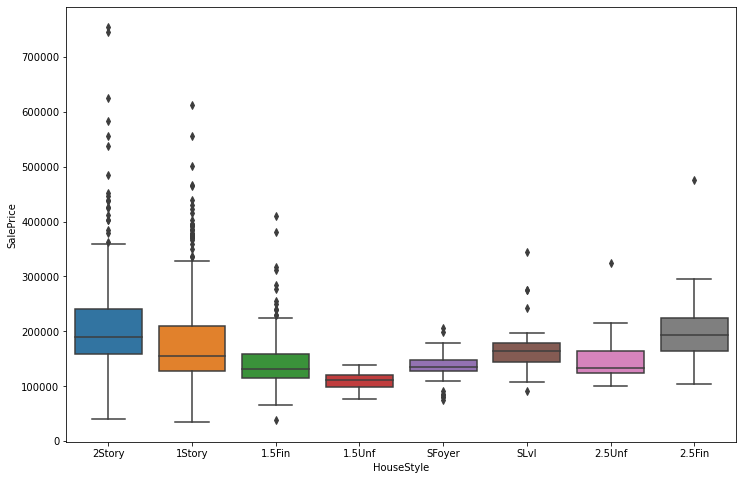

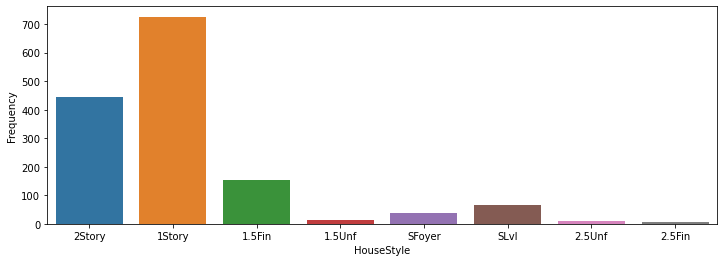

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [27]:
f, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=housing.SalePrice, x=housing.HouseStyle)
plt.show()

# Count of categories within HouseStyle attribute
fig = plt.figure(figsize=(12, 4))
sns.countplot(x='HouseStyle', data=housing)
plt.ylabel('Frequency')
plt.show()


housing.HouseStyle.value_counts()

The most expensive option is the 2story and this option has also the largest variety in prices. 

Most of the houses are 1story.

We can plot the style of the house agaisnt the years to check whether the style has changed over the years.

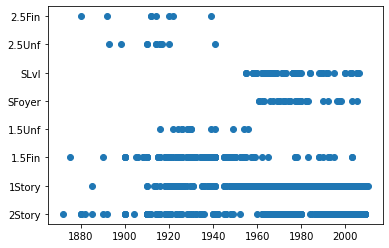

In [28]:
plt.scatter(housing.YearBuilt,housing.HouseStyle)

From the plot above we see that 1Story and 2Story are consistent over the years (a little more frequent in recent years) while 2.5Fin, 2.5Unf and 1.5Unf are all older houses and SFoyer and SLvl are all newer houses.

# Data Preprocessing

## Dealing With Missing Values

We get a sorted count of the missing values for all the attributes.

In [29]:
housing.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
MSSubClass          0
Length: 80, dtype: int64

Most of the categorical atttributes have missing values where the feature is not prensent, for example 'PoolQC' is NaN if the house does not have a pool.

So for the categorical values I will replace the missing values with None, except 'Electrical' (Electrical system), which will be filled with the mode.

Then for 'LotFrontage', which is the linear feet of street connected to property, I will fill the missing value with the median of the value for that attribute in the same neighborhood.

The numerical attributes will be filled with the zero.

The attribute 'Utilities' (Type of utilities available) will be dropped because not interesting for this model.


In [30]:
# Imputing Missing Values

housing_fillNa = housing

# Categorical columns:
cat_cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                     'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType',
                     'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond',
                     'MasVnrType']

# Replace missing values for categorical columns with None
for cat in cat_cols_fill_none:
    housing_fillNa[cat] = housing_fillNa[cat].fillna("None")
    
# Use the mode value for Electrical
housing_fillNa['Electrical'] = housing_fillNa['Electrical'].fillna(housing_fillNa['Electrical']).mode()[0]
    
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
housing_fillNa['LotFrontage'] = housing_fillNa.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))    

# Garage: GarageYrBlt, GarageArea, GarageCars and MasVnrArea these are numerical columns, replace with zero
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']:
    housing_fillNa[col] = housing_fillNa[col].fillna(int(0))

# There is no need of Utilities so let's just drop this column
housing_fillNa = housing_fillNa.drop(['Utilities'], axis=1)

# Get the count again to verify that we do not have any more missing values
housing_fillNa.isnull().apply(sum).max()

0

## Dealing with Outliers 

In order to remove the outliers, we remove the datapoints that are above the 99.9% quantile.

In [31]:
# Numerocal attributes without NaN
num_attr = housing_fillNa.select_dtypes(exclude='object')

quantile = housing_fillNa.quantile(.999)

for col in num_attr.columns:
    housing_fillNa = housing_fillNa.drop(housing_fillNa[col][housing_fillNa[col]>quantile[col]].index)

housing_fillNa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1422 non-null   int64  
 1   MSZoning       1422 non-null   object 
 2   LotFrontage    1422 non-null   float64
 3   LotArea        1422 non-null   int64  
 4   Street         1422 non-null   object 
 5   Alley          1422 non-null   object 
 6   LotShape       1422 non-null   object 
 7   LandContour    1422 non-null   object 
 8   LotConfig      1422 non-null   object 
 9   LandSlope      1422 non-null   object 
 10  Neighborhood   1422 non-null   object 
 11  Condition1     1422 non-null   object 
 12  Condition2     1422 non-null   object 
 13  BldgType       1422 non-null   object 
 14  HouseStyle     1422 non-null   object 
 15  OverallQual    1422 non-null   int64  
 16  OverallCond    1422 non-null   int64  
 17  YearBuilt      1422 non-null   int64  
 18  YearRemo

After removing the outliers, we are now left with 1422 rows.

## Dealing with Correlated Attributes

We remove the highly-correlated features, which we have identified previously. As for GarageArea and GarageCars, they are highly-correlated, however we will drop GarageArea because GarageCars is more correlated with price than area.

In [32]:
#### Remove highly correlated features as identified for excluding in prev scatter plots & corr values
attributes_drop = ['MiscVal', 'MoSold', 'YrSold', 'BsmtFinSF2','BsmtHalfBath','MSSubClass',
                   'GarageArea', 'GarageYrBlt', '3SsnPorch']

housing_fillNa = housing_fillNa.drop(attributes_drop, axis=1)

## Handle Text And Categorical Attributes

We convert categorical number from text to number with one-hot encoding, where the value of the attribute will be 1 if it is present, and 0 if not.

In [33]:
# One-hot encoding of categorical attributes
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_fillNa_1hot = cat_encoder.fit_transform(housing_fillNa)
housing_fillNa_1hot

<1422x7333 sparse matrix of type '<class 'numpy.float64'>'
	with 99540 stored elements in Compressed Sparse Row format>

After this process, we have 7333 attributes, while before we had only 70.

# Data Transformation
## Transformation pipeline

We use the Pipeline class from Scikit-learn to handle missing values, feature scaling and handling categorical attributes. We create a transformation pipeline based on SimpleImputer and StandardScalar classes for the numerical attributes and OneHotEncoder for the categorical ones.



In [35]:
# Numerial pipeline
# Import modules
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Separate features and target variable
housing_X = housing_fillNa.drop("SalePrice", axis=1)
housing_y = housing_fillNa["SalePrice"].copy()

# Get the list of names for numerical and categorical attributes separately
num_attribs = list(housing_X.select_dtypes(exclude='object'))
cat_attribs = list(housing_X.select_dtypes(include='object'))

# Numerical Pipeline to impute any missing values with the median and scale attributes
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])


We use ColumnTransformer to handle both categorical and numerical attributes and apply the transformation to all columns.

The constructor of ColumnTransformer class required a list of tuples containing a name, a transformer and a list of columns which the transformer should be applied to. We specify that the numerical columns should be using the num_pipeline and that the categorical columns should be transformed using a OneHotEncoder. We then apply the constructed ColumnTransformer to the housing data with fit_transform().

In [37]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])


# Description before applying transforms
print(housing_y.describe())

# Apply log-transform to SalePrice
housing_y_prepared  = np.log(housing_y)

# Run the transformation pipeline on all the other attributes
housing_X_prepared = full_pipeline.fit_transform(housing_X)

# Description before applying transforms
print(housing_y_prepared.describe())

housing_X_prepared

count      1422.000000
mean     178405.042897
std       74506.926127
min       35311.000000
25%      129600.000000
50%      161500.000000
75%      211750.000000
max      611657.000000
Name: SalePrice, dtype: float64
count    1422.000000
mean       12.014792
std         0.389594
min        10.471950
25%        11.772207
50%        11.992260
75%        12.263160
max        13.323927
Name: SalePrice, dtype: float64


<1422x281 sparse matrix of type '<class 'numpy.float64'>'
	with 98118 stored elements in Compressed Sparse Row format>